In [1]:
"""
This script analyses the effect on prediction and data integration
of leaving a batch out of training
"""

# imports
import os
import pandas as pd
import numpy as np
import scvi
import torch
import mudata as md
from omicsdgd import DGD
import matplotlib.pyplot as plt
import seaborn as sns
import umap
#from sklearn.metrics import silhouette_score

/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not suppli

In [2]:
####################
# collect test errors per model and sample
####################
# load data
save_dir = "../results/trained_models/"
data_name = "mouse_gastrulation"
mudata = md.read("../../data/mouse_gastrulation.h5mu", backed=False)
train_indices = list(np.where(mudata.obs["train_val_test"] == "train")[0])
test_indices = list(np.where(mudata.obs["train_val_test"] == "test")[0])
trainset = mudata[train_indices, :].copy()
testset = mudata[test_indices, :].copy()
batches = trainset.obs["stage"].unique()
test_batches = testset.obs["stage"].values

batches_left_out = batches
model_names = [
    "mouse_gast_l20_h2-2_rs0_leftout_E7.5"
]

### plots for the original model

In [3]:
# plot the test latent space of the original moel trained on all sites
model_name = "mouse_gast_l20_h2-2_rs0"

model = DGD.load(
    data=trainset,
    save_dir=save_dir + data_name + "/",
    model_name=model_name,
)

CUDA Available: False
Number of GPUs: 0
using device:  cpu

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 5
        
printing all checkpoint keys containing 'correction'
correction_gmm.mean
correction_gmm.neglogvar
correction_gmm.weight
correction_rep.z
correction_val_rep.z
correction_test_rep.z
#######################
Training status
#######################
True


In [4]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.5)
rep = reducer.fit_transform(model.representation.z.detach().cpu().numpy())
# get the gmm means
gmm = reducer.transform(model.gmm.mean.detach().cpu().numpy())

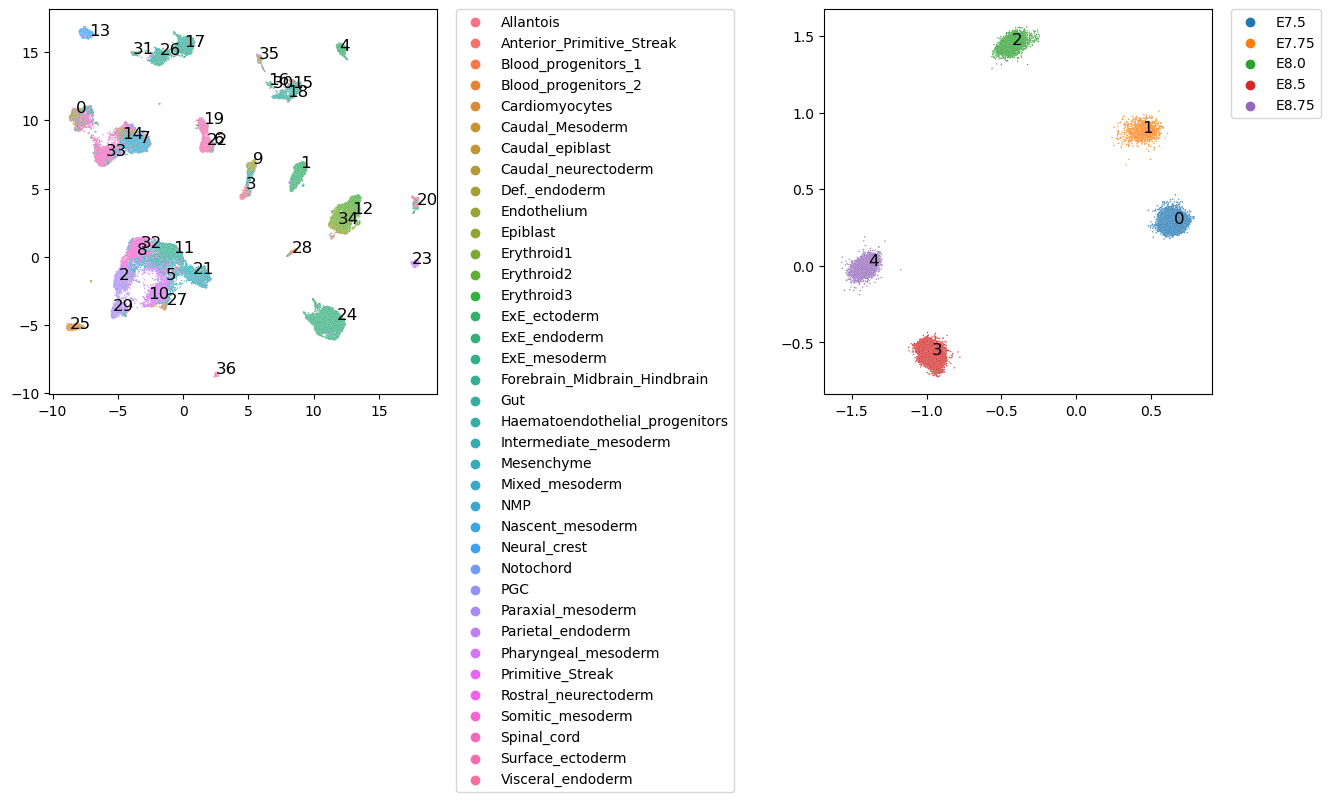

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# adjust spacing
fig.subplots_adjust(wspace=1.)
sns.scatterplot(
    x=rep[:, 0],
    y=rep[:, 1],
    hue=trainset.obs["celltype"].values,
    s=1,
    ax=ax[0]
)
# plot the gmm means as numbers on the plot
for i in range(gmm.shape[0]):
    ax[0].text(gmm[i, 0], gmm[i, 1], str(i), fontsize=12)
sns.scatterplot(
    x=model.correction_rep.z.detach().cpu().numpy()[:, 0],
    y=model.correction_rep.z.detach().cpu().numpy()[:, 1],
    hue=trainset.obs["stage"].values,
    s=1,
    ax=ax[1]
)
for i in range(model.correction_gmm.n_mix_comp):
    ax[1].text(model.correction_gmm.mean.detach().cpu().numpy()[i, 0], model.correction_gmm.mean.detach().cpu().numpy()[i, 1], str(i), fontsize=12)
ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [6]:
rep = reducer.transform(model.test_rep.z.detach().cpu().numpy())

# put the reps in a dataframe so I can randomize the order
plot_df = pd.DataFrame(
    {
        "UMAP D1": rep[:, 0],
        "UMAP D2": rep[:, 1],
        "celltype": testset.obs["celltype"].values,
        "stage D1": model.correction_test_rep.z.detach().cpu().numpy()[:, 0],
        "stage D2": model.correction_test_rep.z.detach().cpu().numpy()[:, 1],
        "stage": testset.obs["stage"].values
    }
)
# randomize the order
plot_df = plot_df.sample(frac=1)

testset


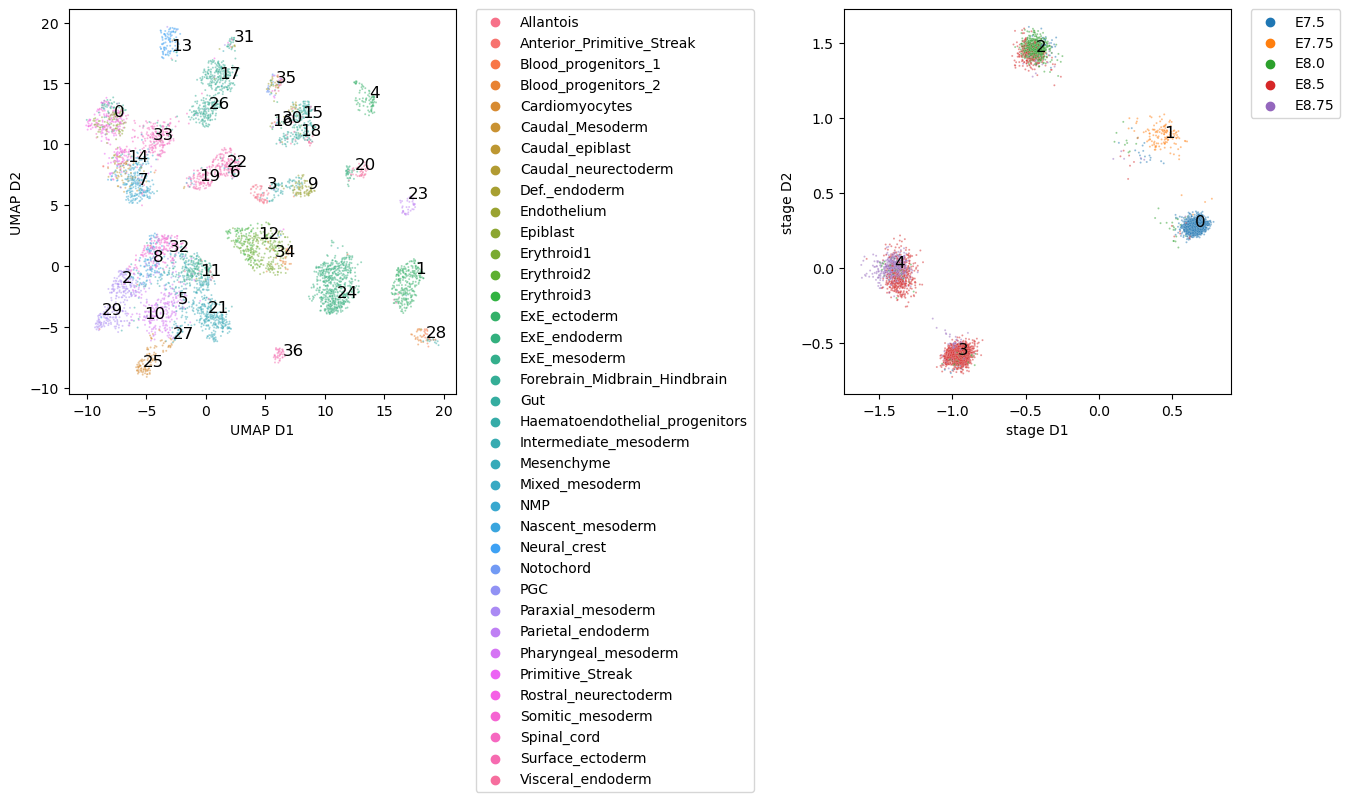

In [8]:
print("testset")
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# adjust spacing
fig.subplots_adjust(wspace=1.)
sns.scatterplot(
    data=plot_df,
    x="UMAP D1",
    y="UMAP D2",
    hue="celltype",
    s=2,
    alpha=0.5,
    ax=ax[0]
)
# plot the gmm means as numbers on the plot
for i in range(gmm.shape[0]):
    ax[0].text(gmm[i, 0], gmm[i, 1], str(i), fontsize=12)
sns.scatterplot(
    data=plot_df,
    x="stage D1",
    y="stage D2",
    hue="stage",
    s=2,
    alpha=0.5,
    ax=ax[1]
)
for i in range(model.correction_gmm.n_mix_comp):
    ax[1].text(model.correction_gmm.mean.detach().cpu().numpy()[i, 0], model.correction_gmm.mean.detach().cpu().numpy()[i, 1], str(i), fontsize=12)
ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [4]:
# get the components that the train samples are in (for basal and covariate)
train_basal_clusters = torch.argmax(model.gmm.sample_probs(model.representation.z),dim=-1).to(torch.int16)
train_covariate_clusters = torch.argmax(model.correction_gmm.sample_probs(model.correction_rep.z),dim=-1).to(torch.int16)
test_basal_clusters = torch.argmax(model.gmm.sample_probs(model.test_rep.z),dim=-1).to(torch.int16)
test_covariate_clusters = torch.argmax(model.correction_gmm.sample_probs(model.correction_test_rep.z),dim=-1).to(torch.int16)

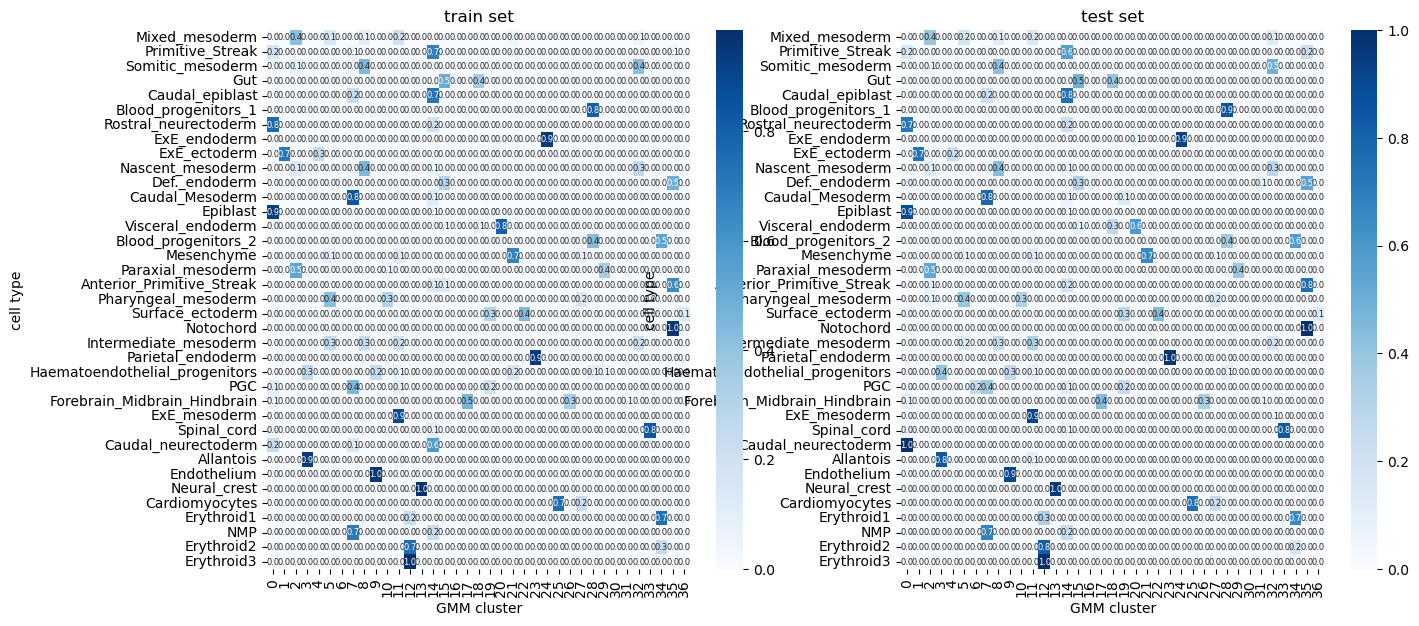

In [5]:
# make a confusion matrix showing the fraction of cells in each cluster
# first for cell types and gmm clusters for train and test sets
# second for sites and correction_gmm clusters

# for cell types
# first make the confusion matrix
celltypes = trainset.obs["celltype"].unique()
confusion_matrix = np.zeros((len(celltypes), model.gmm.n_mix_comp))
confusion_matrix_test = np.zeros((len(celltypes), model.gmm.n_mix_comp))
for i, celltype in enumerate(celltypes):
    # get the indices of the trainset that are of this celltype
    celltype_indices = np.where(trainset.obs["celltype"].values == celltype)[0]
    celltype_indices_test = np.where(testset.obs["celltype"].values == celltype)[0]
    # get the clusters that these indices are in
    clusters = train_basal_clusters[celltype_indices].cpu().numpy()
    clusters_test = test_basal_clusters[celltype_indices_test].cpu().numpy()
    # count the number of cells in each cluster
    for cluster in range(model.gmm.n_mix_comp):
        confusion_matrix[i, cluster] = np.sum(clusters == cluster) / len(celltype_indices)
        confusion_matrix_test[i, cluster] = np.sum(clusters_test == cluster) / len(celltype_indices_test)
# normalize the confusion matrix
#confusion_matrix = confusion_matrix / np.sum(confusion_matrix, axis=0)
#confusion_matrix_test = confusion_matrix_test / np.sum(confusion_matrix_test, axis=0)
# plot the confusion matrix
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
sns.heatmap(confusion_matrix, cmap="Blues", annot=True, xticklabels=np.arange(model.gmm.n_mix_comp), yticklabels=celltypes, fmt=".1f", ax=ax[0], annot_kws={"fontsize": 6})
ax[0].set_xlabel("GMM cluster")
ax[0].set_ylabel("cell type")
ax[0].set_title("train set")
sns.heatmap(confusion_matrix_test, cmap="Blues", annot=True, xticklabels=np.arange(model.gmm.n_mix_comp), yticklabels=celltypes, fmt=".1f", ax=ax[1], annot_kws={"fontsize": 6})
ax[1].set_xlabel("GMM cluster")
ax[1].set_ylabel("cell type")
ax[1].set_title("test set")
plt.show()

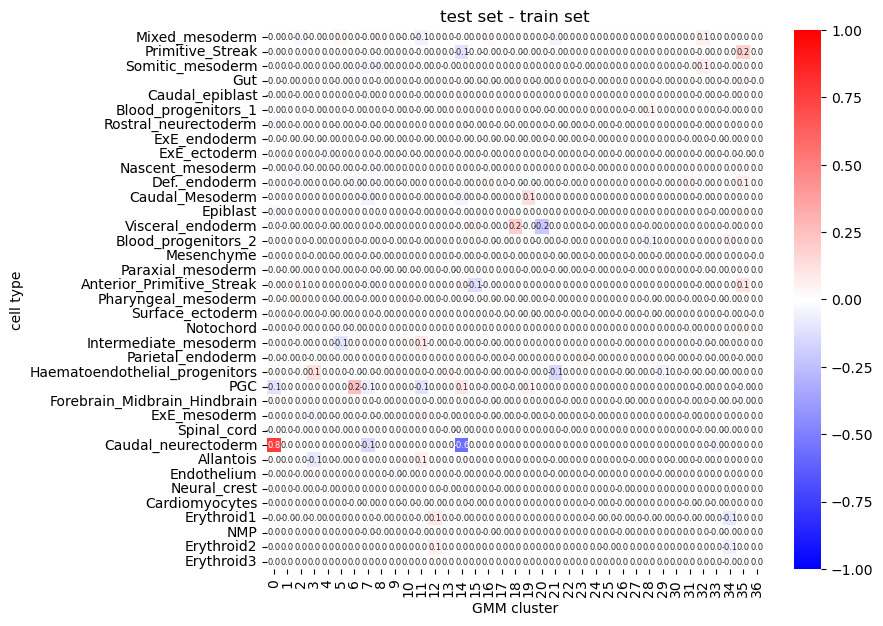

In [7]:
# now plot a heatmap of the difference
fig, ax = plt.subplots(1, 1, figsize=(8, 7))
sns.heatmap(
    confusion_matrix_test - confusion_matrix,
    cmap="bwr",
    annot=True,
    xticklabels=np.arange(model.gmm.n_mix_comp),
    yticklabels=celltypes,
    fmt=".1f",
    ax=ax,
    annot_kws={"fontsize": 6},
    vmin=-1,
    vmax=1,
)
ax.set_xlabel("GMM cluster")
ax.set_ylabel("cell type")
ax.set_title("test set - train set")
plt.show()

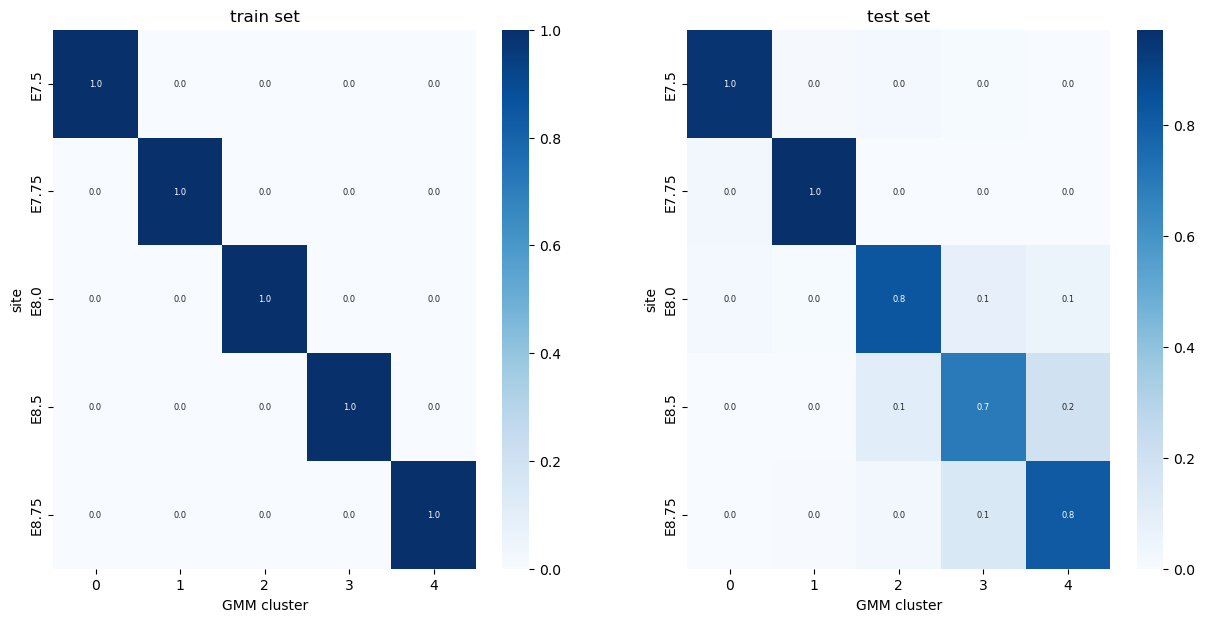

In [8]:
# same for covariates

sites = trainset.obs["stage"].unique()
confusion_matrix = np.zeros((len(sites), model.correction_gmm.n_mix_comp))
confusion_matrix_test = np.zeros((len(sites), model.correction_gmm.n_mix_comp))
for i, site in enumerate(sites):
    # get the indices of the trainset that are of this celltype
    site_indices = np.where(trainset.obs["stage"].values == site)[0]
    site_indices_test = np.where(testset.obs["stage"].values == site)[0]
    # get the clusters that these indices are in
    clusters = train_covariate_clusters[site_indices].cpu().numpy()
    clusters_test = test_covariate_clusters[site_indices_test].cpu().numpy()
    # count the number of cells in each cluster
    for cluster in range(model.correction_gmm.n_mix_comp):
        confusion_matrix[i, cluster] = np.sum(clusters == cluster) / len(site_indices)
        confusion_matrix_test[i, cluster] = np.sum(clusters_test == cluster) / len(site_indices_test)

# plot the confusion matrix
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
sns.heatmap(confusion_matrix, cmap="Blues", annot=True, xticklabels=np.arange(model.correction_gmm.n_mix_comp), yticklabels=sites, fmt=".1f", ax=ax[0], annot_kws={"fontsize": 6})
ax[0].set_xlabel("GMM cluster")
ax[0].set_ylabel("site")
ax[0].set_title("train set")
sns.heatmap(confusion_matrix_test, cmap="Blues", annot=True, xticklabels=np.arange(model.correction_gmm.n_mix_comp), yticklabels=sites, fmt=".1f", ax=ax[1], annot_kws={"fontsize": 6})
ax[1].set_xlabel("GMM cluster")
ax[1].set_ylabel("site")
ax[1].set_title("test set")
plt.show()

### unsupervised

In [3]:
i = 0
model_name = "mouse_gast_l20_h2-2_rs0_leftout_E7.5_test50e_default"

# load model
train_indices = [
    x
    for x in np.arange(len(trainset))
    if trainset.obs["stage"].values[x] != batches_left_out[i]
]
model = DGD.load(
    data=trainset[train_indices],
    save_dir=save_dir + data_name + "/",
    model_name=model_name,
)

CUDA Available: False
Number of GPUs: 0
using device:  cpu

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 4
        
printing all checkpoint keys containing 'correction'
correction_gmm.mean
correction_gmm.neglogvar
correction_gmm.weight
correction_rep.z
correction_val_rep.z
correction_test_rep.z
#######################
Training status
#######################
True


In [12]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.5)
rep = reducer.fit_transform(model.representation.z.detach().cpu().numpy())
# get the gmm means
gmm = reducer.transform(model.gmm.mean.detach().cpu().numpy())

In [13]:
# put the reps in a dataframe so I can randomize the order
plot_df = pd.DataFrame(
    {
        "UMAP D1": rep[:, 0],
        "UMAP D2": rep[:, 1],
        "celltype": trainset.obs["celltype"].values[train_indices],
        "stage D1": model.correction_rep.z.detach().cpu().numpy()[:, 0],
        "stage D2": model.correction_rep.z.detach().cpu().numpy()[:, 1],
        "stage": trainset.obs["stage"].values[train_indices]
    }
)
# randomize the order
plot_df = plot_df.sample(frac=1)

trainset


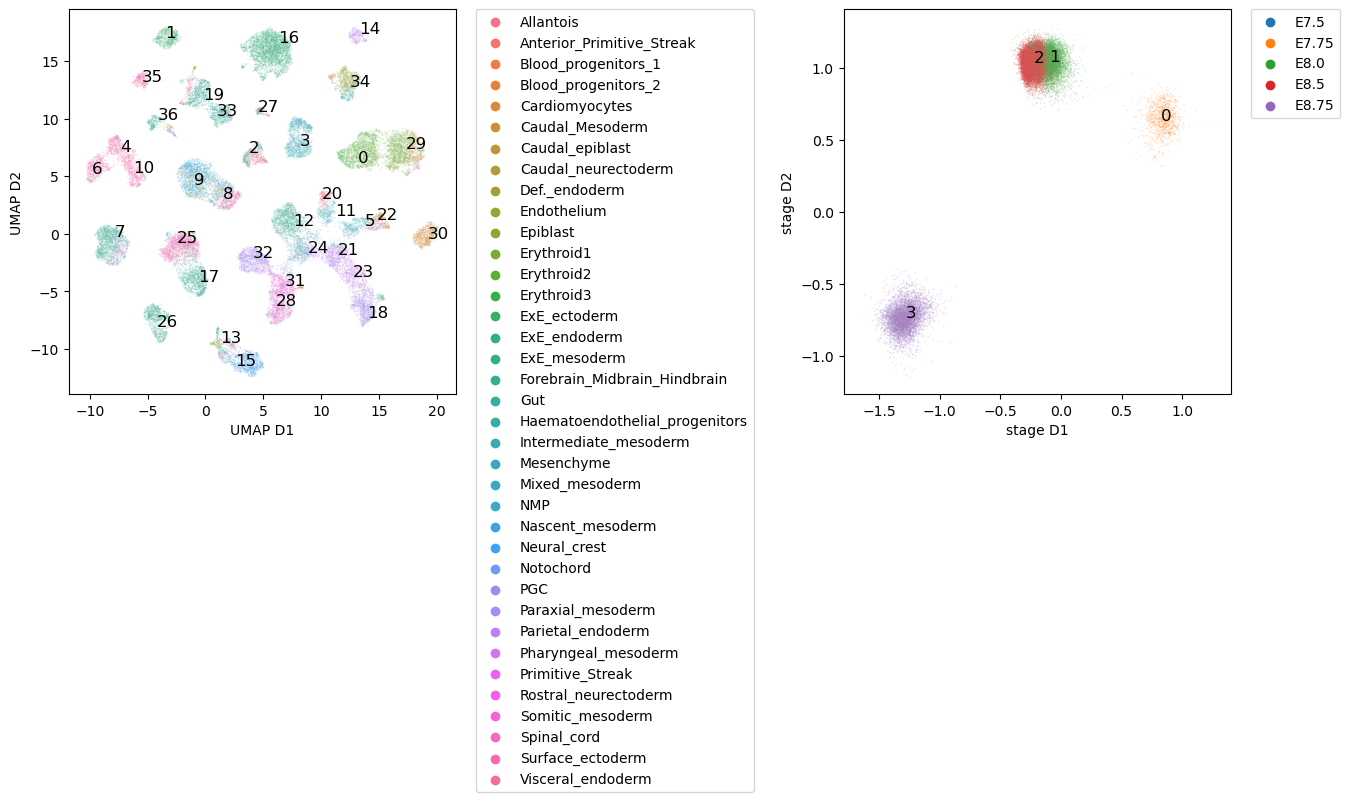

In [14]:
print("trainset")
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# adjust spacing
fig.subplots_adjust(wspace=1.)
sns.scatterplot(
    data=plot_df,
    x="UMAP D1",
    y="UMAP D2",
    hue="celltype",
    s=1,
    alpha=0.2,
    ax=ax[0]
)
# plot the gmm means as numbers on the plot
for i in range(gmm.shape[0]):
    ax[0].text(gmm[i, 0], gmm[i, 1], str(i), fontsize=12)
sns.scatterplot(
    data=plot_df,
    x="stage D1",
    y="stage D2",
    hue="stage",
    s=1,
    alpha=0.2,
    ax=ax[1]
)
for i in range(model.correction_gmm.n_mix_comp):
    ax[1].text(model.correction_gmm.mean.detach().cpu().numpy()[i, 0], model.correction_gmm.mean.detach().cpu().numpy()[i, 1], str(i), fontsize=12)
ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

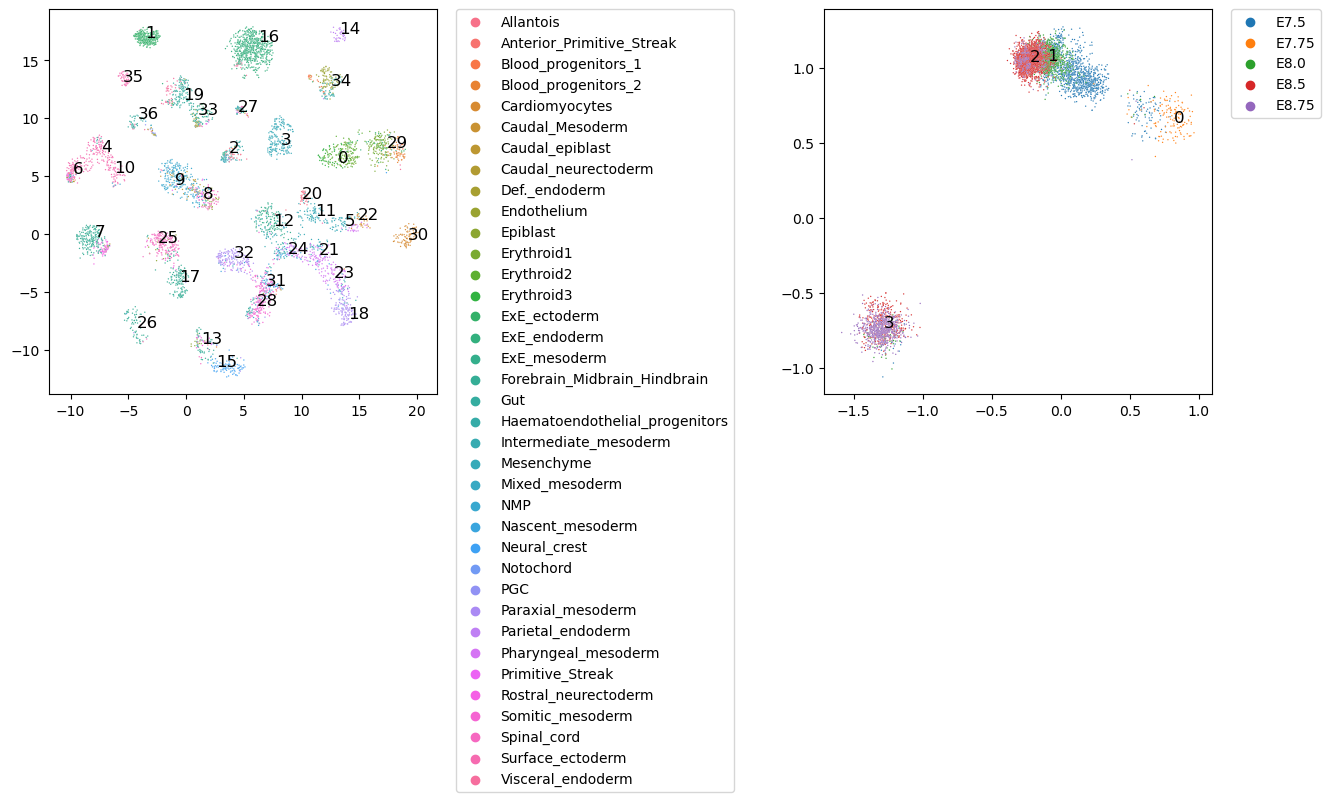

In [15]:
rep = reducer.transform(model.test_rep.z.detach().cpu().numpy())

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# adjust spacing
fig.subplots_adjust(wspace=1.)
sns.scatterplot(
    x=rep[:, 0],
    y=rep[:, 1],
    hue=testset.obs["celltype"].values,
    s=1,
    ax=ax[0]
)
# plot the gmm means as numbers on the plot
for i in range(gmm.shape[0]):
    ax[0].text(gmm[i, 0], gmm[i, 1], str(i), fontsize=12)
sns.scatterplot(
    x=model.correction_test_rep.z.detach().cpu().numpy()[:, 0],
    y=model.correction_test_rep.z.detach().cpu().numpy()[:, 1],
    hue=testset.obs["stage"].values,
    s=1,
    ax=ax[1]
)
for i in range(model.correction_gmm.n_mix_comp):
    ax[1].text(model.correction_gmm.mean.detach().cpu().numpy()[i, 0], model.correction_gmm.mean.detach().cpu().numpy()[i, 1], str(i), fontsize=12)
ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

/var/folders/tp/pr1hfl8527z35j1791t_j9bc0000gn/T/ipykernel_4660/2377522760.py:19: RuntimeWarning: invalid value encountered in scalar divide
  confusion_matrix[i, cluster] = np.sum(clusters == cluster) / len(site_indices)


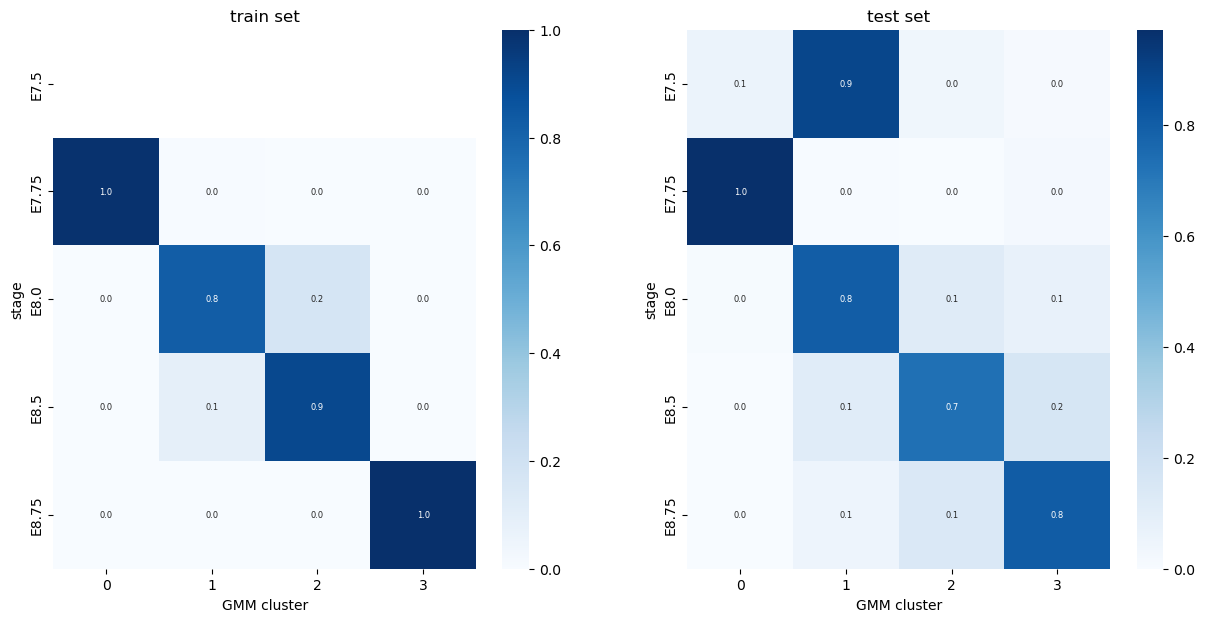

In [15]:
# get the components that the train samples are in (for basal and covariate)
train_basal_clusters = torch.argmax(model.gmm.sample_probs(model.representation.z),dim=-1).to(torch.int16)
train_covariate_clusters = torch.argmax(model.correction_gmm.sample_probs(model.correction_rep.z),dim=-1).to(torch.int16)
test_basal_clusters = torch.argmax(model.gmm.sample_probs(model.test_rep.z),dim=-1).to(torch.int16)
test_covariate_clusters = torch.argmax(model.correction_gmm.sample_probs(model.correction_test_rep.z),dim=-1).to(torch.int16)

sites = trainset.obs["stage"].unique()
confusion_matrix = np.zeros((len(sites), model.correction_gmm.n_mix_comp))
confusion_matrix_test = np.zeros((len(sites), model.correction_gmm.n_mix_comp))
for i, site in enumerate(sites):
    # get the indices of the trainset that are of this celltype
    site_indices = np.where(trainset[train_indices].obs["stage"].values == site)[0]
    site_indices_test = np.where(testset.obs["stage"].values == site)[0]
    # get the clusters that these indices are in
    clusters = train_covariate_clusters[site_indices].cpu().numpy()
    clusters_test = test_covariate_clusters[site_indices_test].cpu().numpy()
    # count the number of cells in each cluster
    for cluster in range(model.correction_gmm.n_mix_comp):
        confusion_matrix[i, cluster] = np.sum(clusters == cluster) / len(site_indices)
        confusion_matrix_test[i, cluster] = np.sum(clusters_test == cluster) / len(site_indices_test)

# plot the confusion matrix
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
sns.heatmap(confusion_matrix, cmap="Blues", annot=True, xticklabels=np.arange(model.correction_gmm.n_mix_comp), yticklabels=sites, fmt=".1f", ax=ax[0], annot_kws={"fontsize": 6})
ax[0].set_xlabel("GMM cluster")
ax[0].set_ylabel("stage")
ax[0].set_title("train set")
sns.heatmap(confusion_matrix_test, cmap="Blues", annot=True, xticklabels=np.arange(model.correction_gmm.n_mix_comp), yticklabels=sites, fmt=".1f", ax=ax[1], annot_kws={"fontsize": 6})
ax[1].set_xlabel("GMM cluster")
ax[1].set_ylabel("stage")
ax[1].set_title("test set")
plt.show()

### supervised

beta = 1

In [17]:
i = 0
model_name = "mouse_gast_l20_h2-2_rs0_leftout_E7.5_test50e_covSupervised"

# load model
train_indices = [
    x
    for x in np.arange(len(trainset))
    if trainset.obs["stage"].values[x] != batches_left_out[i]
]
model = DGD.load(
    data=trainset[train_indices],
    save_dir=save_dir + data_name + "/",
    model_name=model_name,
)

CUDA Available: False
Number of GPUs: 0
using device:  cpu

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 4
        
printing all checkpoint keys containing 'correction'
correction_gmm.mean
correction_gmm.neglogvar
correction_gmm.weight
correction_rep.z
correction_val_rep.z
correction_test_rep.z
#######################
Training status
#######################
True


In [18]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.5)
rep = reducer.fit_transform(model.representation.z.detach().cpu().numpy())
# get the gmm means
gmm = reducer.transform(model.gmm.mean.detach().cpu().numpy())

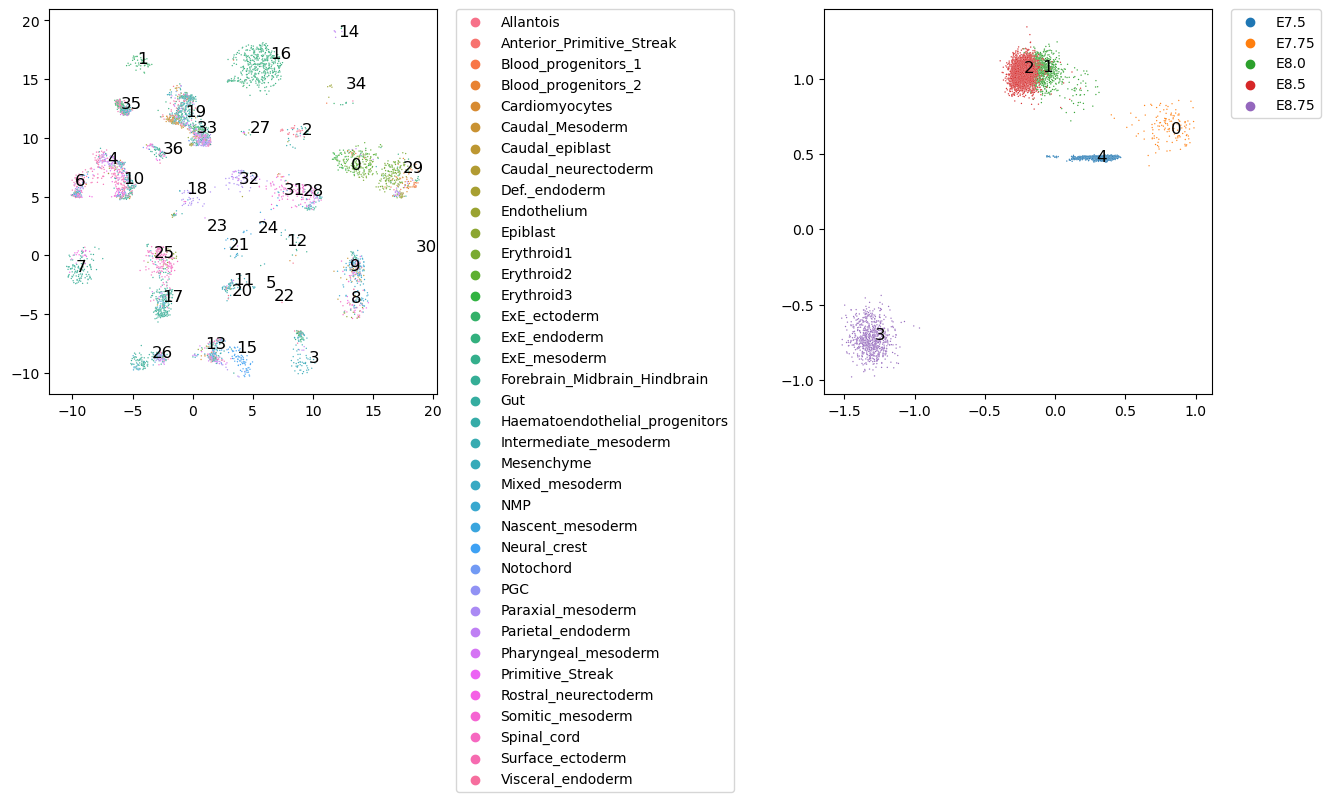

In [19]:
rep = reducer.transform(model.test_rep.z.detach().cpu().numpy())

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# adjust spacing
fig.subplots_adjust(wspace=1.)
sns.scatterplot(
    x=rep[:, 0],
    y=rep[:, 1],
    hue=testset.obs["celltype"].values,
    s=1,
    ax=ax[0]
)
# plot the gmm means as numbers on the plot
for i in range(gmm.shape[0]):
    ax[0].text(gmm[i, 0], gmm[i, 1], str(i), fontsize=12)
sns.scatterplot(
    x=model.correction_test_rep.z.detach().cpu().numpy()[:, 0],
    y=model.correction_test_rep.z.detach().cpu().numpy()[:, 1],
    hue=testset.obs["stage"].values,
    s=1,
    ax=ax[1]
)
for i in range(model.correction_gmm.n_mix_comp):
    ax[1].text(model.correction_gmm.mean.detach().cpu().numpy()[i, 0], model.correction_gmm.mean.detach().cpu().numpy()[i, 1], str(i), fontsize=12)
ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

/var/folders/tp/pr1hfl8527z35j1791t_j9bc0000gn/T/ipykernel_4660/2377522760.py:19: RuntimeWarning: invalid value encountered in scalar divide
  confusion_matrix[i, cluster] = np.sum(clusters == cluster) / len(site_indices)


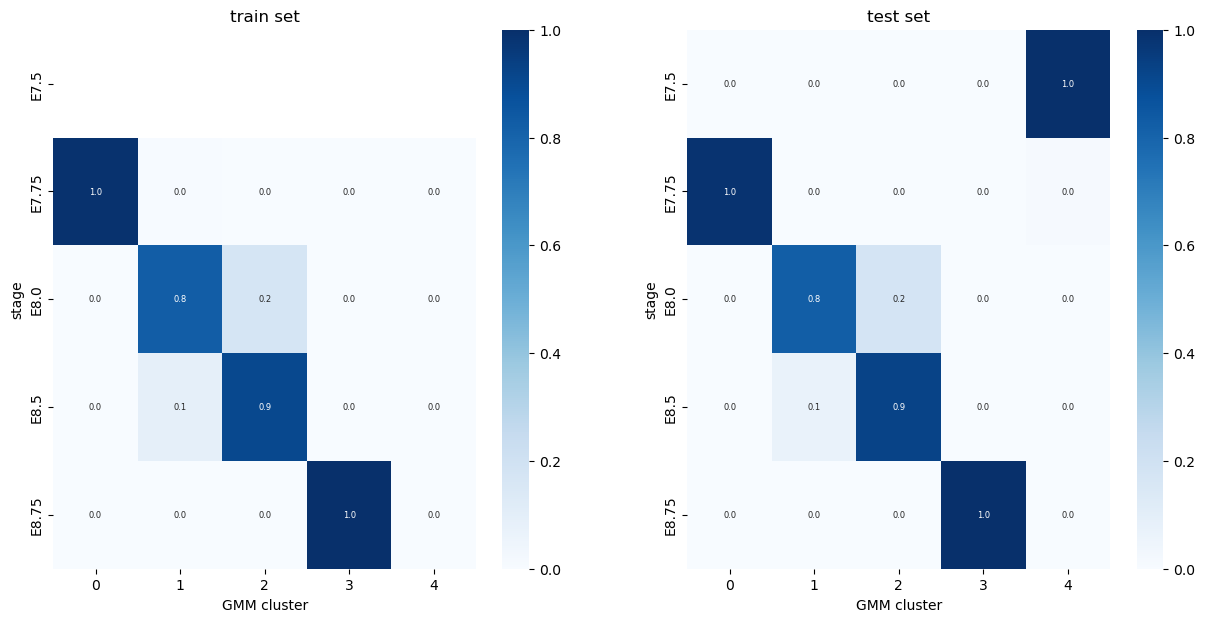

In [11]:
# get the components that the train samples are in (for basal and covariate)
train_basal_clusters = torch.argmax(model.gmm.sample_probs(model.representation.z),dim=-1).to(torch.int16)
train_covariate_clusters = torch.argmax(model.correction_gmm.sample_probs(model.correction_rep.z),dim=-1).to(torch.int16)
test_basal_clusters = torch.argmax(model.gmm.sample_probs(model.test_rep.z),dim=-1).to(torch.int16)
test_covariate_clusters = torch.argmax(model.correction_gmm.sample_probs(model.correction_test_rep.z),dim=-1).to(torch.int16)

sites = trainset.obs["stage"].unique()
confusion_matrix = np.zeros((len(sites), model.correction_gmm.n_mix_comp))
confusion_matrix_test = np.zeros((len(sites), model.correction_gmm.n_mix_comp))
for i, site in enumerate(sites):
    # get the indices of the trainset that are of this celltype
    site_indices = np.where(trainset[train_indices].obs["stage"].values == site)[0]
    site_indices_test = np.where(testset.obs["stage"].values == site)[0]
    # get the clusters that these indices are in
    clusters = train_covariate_clusters[site_indices].cpu().numpy()
    clusters_test = test_covariate_clusters[site_indices_test].cpu().numpy()
    # count the number of cells in each cluster
    for cluster in range(model.correction_gmm.n_mix_comp):
        confusion_matrix[i, cluster] = np.sum(clusters == cluster) / len(site_indices)
        confusion_matrix_test[i, cluster] = np.sum(clusters_test == cluster) / len(site_indices_test)

# plot the confusion matrix
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
sns.heatmap(confusion_matrix, cmap="Blues", annot=True, xticklabels=np.arange(model.correction_gmm.n_mix_comp), yticklabels=sites, fmt=".1f", ax=ax[0], annot_kws={"fontsize": 6})
ax[0].set_xlabel("GMM cluster")
ax[0].set_ylabel("stage")
ax[0].set_title("train set")
sns.heatmap(confusion_matrix_test, cmap="Blues", annot=True, xticklabels=np.arange(model.correction_gmm.n_mix_comp), yticklabels=sites, fmt=".1f", ax=ax[1], annot_kws={"fontsize": 6})
ax[1].set_xlabel("GMM cluster")
ax[1].set_ylabel("stage")
ax[1].set_title("test set")
plt.show()

In [32]:
model = None

In [21]:
i = 0
model_name = "mouse_gast_l20_h2-2_rs0_leftout_E7.5_test50e_covSupervised_beta2"

# load model
train_indices = [
    x
    for x in np.arange(len(trainset))
    if trainset.obs["stage"].values[x] != batches_left_out[i]
]
model = DGD.load(
    data=trainset[train_indices],
    save_dir=save_dir + data_name + "/",
    model_name=model_name,
)

CUDA Available: False
Number of GPUs: 0
using device:  cpu

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 4
        
printing all checkpoint keys containing 'correction'
correction_gmm.mean
correction_gmm.neglogvar
correction_gmm.weight
correction_rep.z
correction_val_rep.z
correction_test_rep.z
#######################
Training status
#######################
True


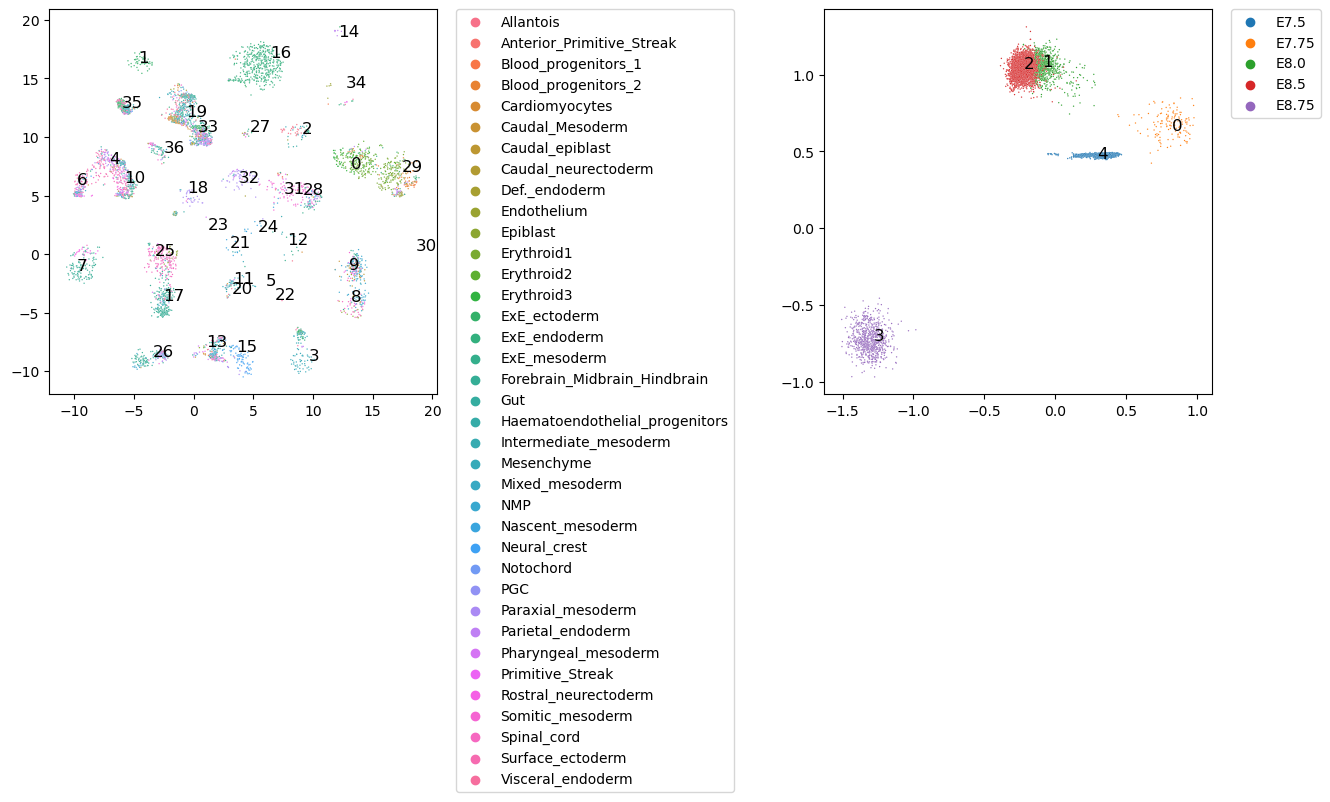

In [22]:
rep = reducer.transform(model.test_rep.z.detach().cpu().numpy())

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# adjust spacing
fig.subplots_adjust(wspace=1.)
sns.scatterplot(
    x=rep[:, 0],
    y=rep[:, 1],
    hue=testset.obs["celltype"].values,
    s=1,
    ax=ax[0]
)
# plot the gmm means as numbers on the plot
for i in range(gmm.shape[0]):
    ax[0].text(gmm[i, 0], gmm[i, 1], str(i), fontsize=12)
sns.scatterplot(
    x=model.correction_test_rep.z.detach().cpu().numpy()[:, 0],
    y=model.correction_test_rep.z.detach().cpu().numpy()[:, 1],
    hue=testset.obs["stage"].values,
    s=1,
    ax=ax[1]
)
for i in range(model.correction_gmm.n_mix_comp):
    ax[1].text(model.correction_gmm.mean.detach().cpu().numpy()[i, 0], model.correction_gmm.mean.detach().cpu().numpy()[i, 1], str(i), fontsize=12)
ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [24]:
i = 0
model_name = "mouse_gast_l20_h2-2_rs0_leftout_E7.5_test50e_covSupervised_beta5"

# load model
train_indices = [
    x
    for x in np.arange(len(trainset))
    if trainset.obs["stage"].values[x] != batches_left_out[i]
]
model = DGD.load(
    data=trainset[train_indices],
    save_dir=save_dir + data_name + "/",
    model_name=model_name,
)

CUDA Available: False
Number of GPUs: 0
using device:  cpu

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 4
        
printing all checkpoint keys containing 'correction'
correction_gmm.mean
correction_gmm.neglogvar
correction_gmm.weight
correction_rep.z
correction_val_rep.z
correction_test_rep.z
#######################
Training status
#######################
True


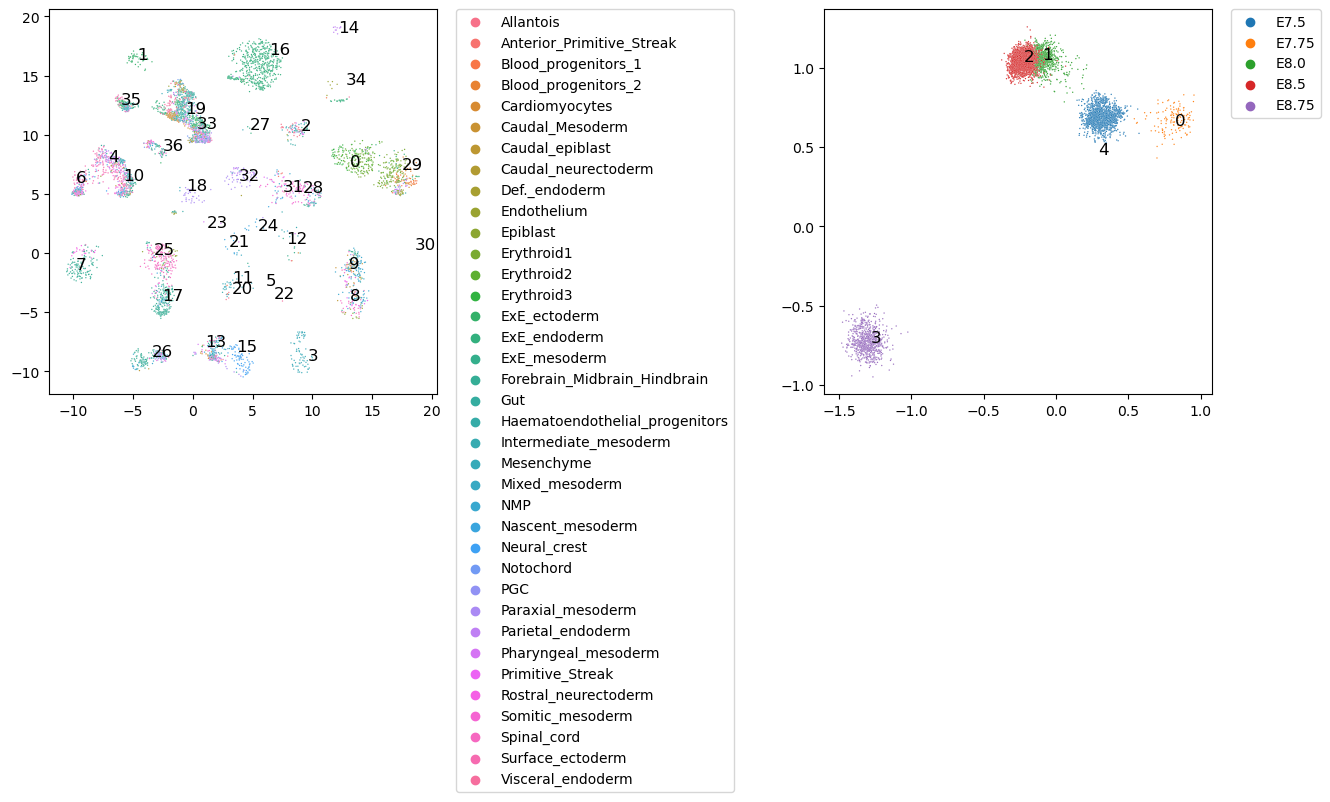

In [25]:
rep = reducer.transform(model.test_rep.z.detach().cpu().numpy())

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# adjust spacing
fig.subplots_adjust(wspace=1.)
sns.scatterplot(
    x=rep[:, 0],
    y=rep[:, 1],
    hue=testset.obs["celltype"].values,
    s=1,
    ax=ax[0]
)
# plot the gmm means as numbers on the plot
for i in range(gmm.shape[0]):
    ax[0].text(gmm[i, 0], gmm[i, 1], str(i), fontsize=12)
sns.scatterplot(
    x=model.correction_test_rep.z.detach().cpu().numpy()[:, 0],
    y=model.correction_test_rep.z.detach().cpu().numpy()[:, 1],
    hue=testset.obs["stage"].values,
    s=1,
    ax=ax[1]
)
for i in range(model.correction_gmm.n_mix_comp):
    ax[1].text(model.correction_gmm.mean.detach().cpu().numpy()[i, 0], model.correction_gmm.mean.detach().cpu().numpy()[i, 1], str(i), fontsize=12)
ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [27]:
i = 0
model_name = "mouse_gast_l20_h2-2_rs0_leftout_E7.5_test50e_covSupervised_beta10"

# load model
train_indices = [
    x
    for x in np.arange(len(trainset))
    if trainset.obs["stage"].values[x] != batches_left_out[i]
]
model = DGD.load(
    data=trainset[train_indices],
    save_dir=save_dir + data_name + "/",
    model_name=model_name,
)

CUDA Available: False
Number of GPUs: 0
using device:  cpu

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 4
        
printing all checkpoint keys containing 'correction'
correction_gmm.mean
correction_gmm.neglogvar
correction_gmm.weight
correction_rep.z
correction_val_rep.z
correction_test_rep.z
#######################
Training status
#######################
True


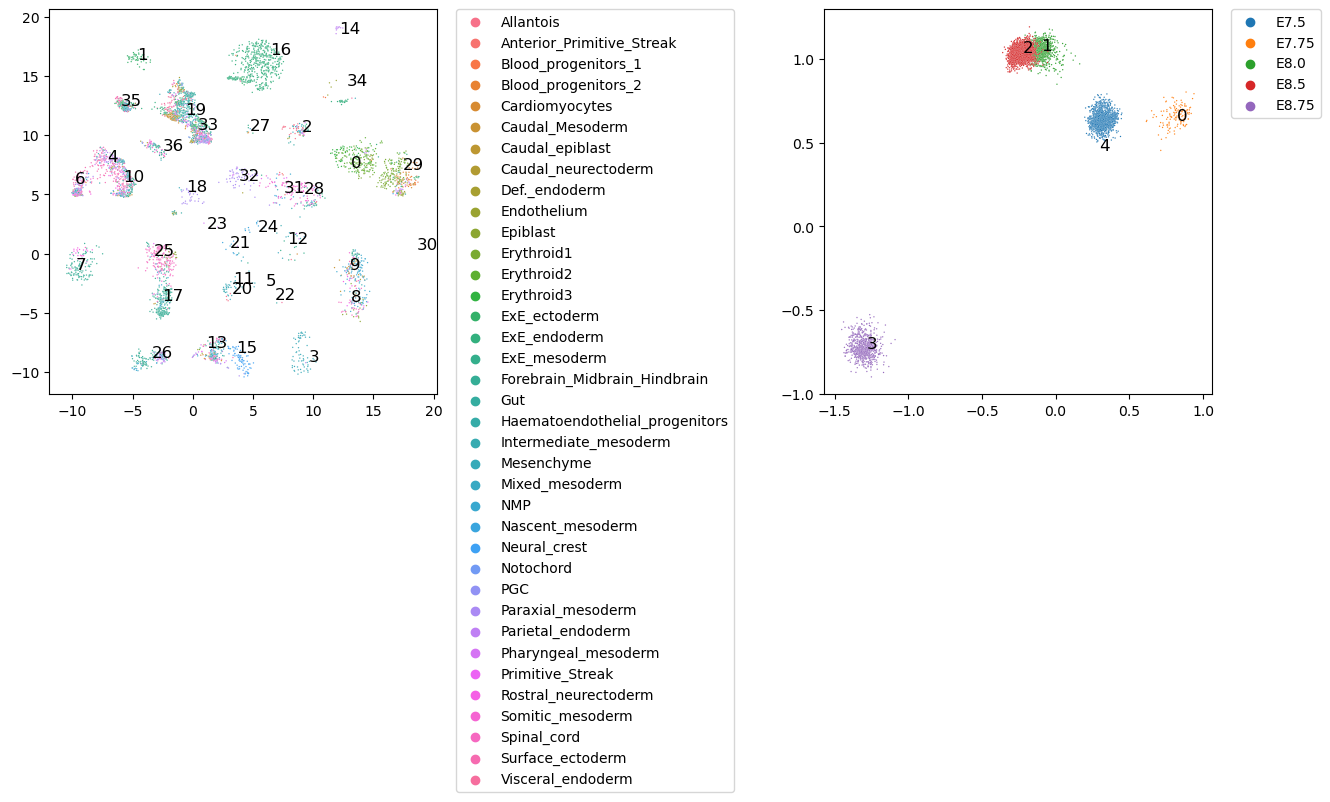

In [28]:
rep = reducer.transform(model.test_rep.z.detach().cpu().numpy())

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# adjust spacing
fig.subplots_adjust(wspace=1.)
sns.scatterplot(
    x=rep[:, 0],
    y=rep[:, 1],
    hue=testset.obs["celltype"].values,
    s=1,
    ax=ax[0]
)
# plot the gmm means as numbers on the plot
for i in range(gmm.shape[0]):
    ax[0].text(gmm[i, 0], gmm[i, 1], str(i), fontsize=12)
sns.scatterplot(
    x=model.correction_test_rep.z.detach().cpu().numpy()[:, 0],
    y=model.correction_test_rep.z.detach().cpu().numpy()[:, 1],
    hue=testset.obs["stage"].values,
    s=1,
    ax=ax[1]
)
for i in range(model.correction_gmm.n_mix_comp):
    ax[1].text(model.correction_gmm.mean.detach().cpu().numpy()[i, 0], model.correction_gmm.mean.detach().cpu().numpy()[i, 1], str(i), fontsize=12)
ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [30]:
i = 0
model_name = "mouse_gast_l20_h2-2_rs0_leftout_E7.5_test50e_covSupervised_beta50"

# load model
train_indices = [
    x
    for x in np.arange(len(trainset))
    if trainset.obs["stage"].values[x] != batches_left_out[i]
]
model = DGD.load(
    data=trainset[train_indices],
    save_dir=save_dir + data_name + "/",
    model_name=model_name,
)

CUDA Available: False
Number of GPUs: 0
using device:  cpu

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 4
        
printing all checkpoint keys containing 'correction'
correction_gmm.mean
correction_gmm.neglogvar
correction_gmm.weight
correction_rep.z
correction_val_rep.z
correction_test_rep.z
#######################
Training status
#######################
True


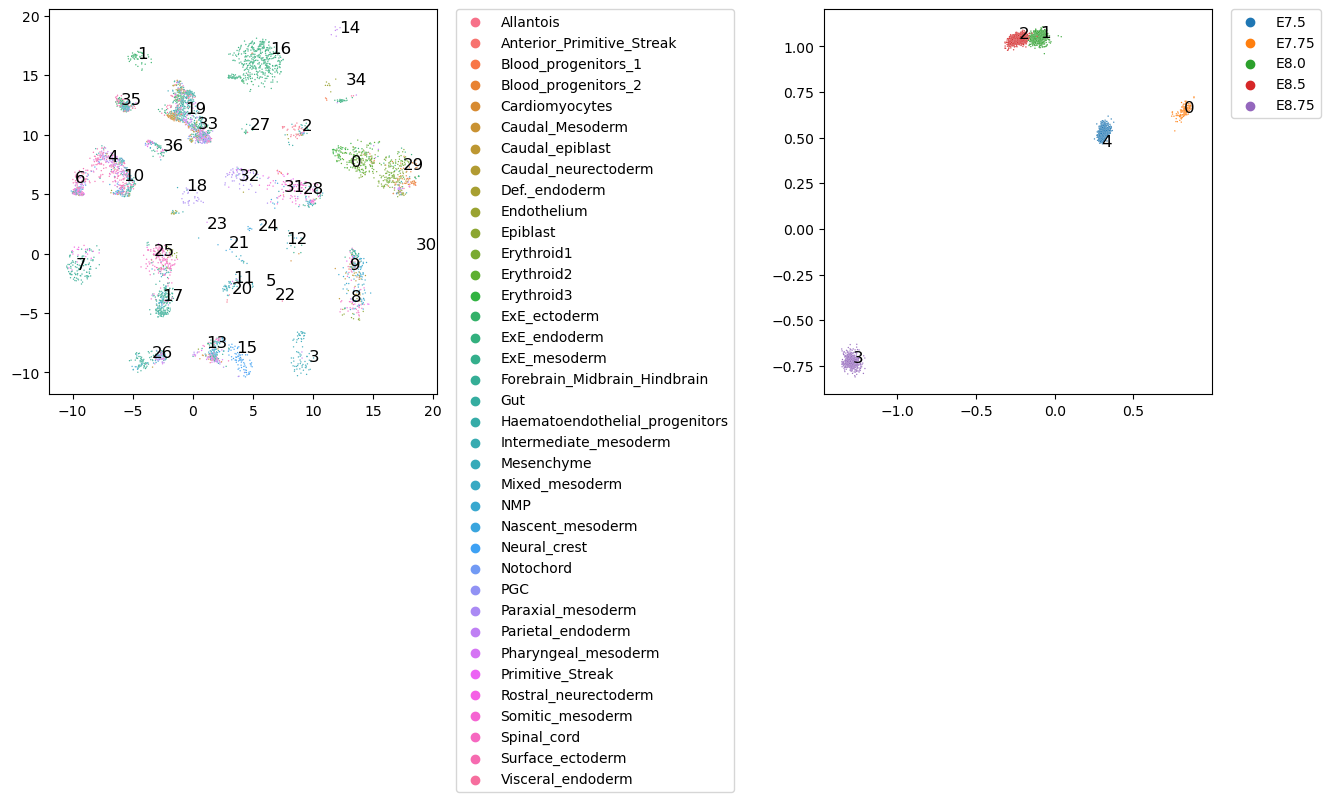

In [31]:
rep = reducer.transform(model.test_rep.z.detach().cpu().numpy())

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# adjust spacing
fig.subplots_adjust(wspace=1.)
sns.scatterplot(
    x=rep[:, 0],
    y=rep[:, 1],
    hue=testset.obs["celltype"].values,
    s=1,
    ax=ax[0]
)
# plot the gmm means as numbers on the plot
for i in range(gmm.shape[0]):
    ax[0].text(gmm[i, 0], gmm[i, 1], str(i), fontsize=12)
sns.scatterplot(
    x=model.correction_test_rep.z.detach().cpu().numpy()[:, 0],
    y=model.correction_test_rep.z.detach().cpu().numpy()[:, 1],
    hue=testset.obs["stage"].values,
    s=1,
    ax=ax[1]
)
for i in range(model.correction_gmm.n_mix_comp):
    ax[1].text(model.correction_gmm.mean.detach().cpu().numpy()[i, 0], model.correction_gmm.mean.detach().cpu().numpy()[i, 1], str(i), fontsize=12)
ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [33]:
i = 0
model_name = "mouse_gast_l20_h2-2_rs0_leftout_E7.5_test100e_covSupervised_beta5_lrGMM001"

# load model
train_indices = [
    x
    for x in np.arange(len(trainset))
    if trainset.obs["stage"].values[x] != batches_left_out[i]
]
model = DGD.load(
    data=trainset[train_indices],
    save_dir=save_dir + data_name + "/",
    model_name=model_name,
)

CUDA Available: False
Number of GPUs: 0
using device:  cpu

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 4
        
printing all checkpoint keys containing 'correction'
correction_gmm.mean
correction_gmm.neglogvar
correction_gmm.weight
correction_rep.z
correction_val_rep.z
correction_test_rep.z
#######################
Training status
#######################
True


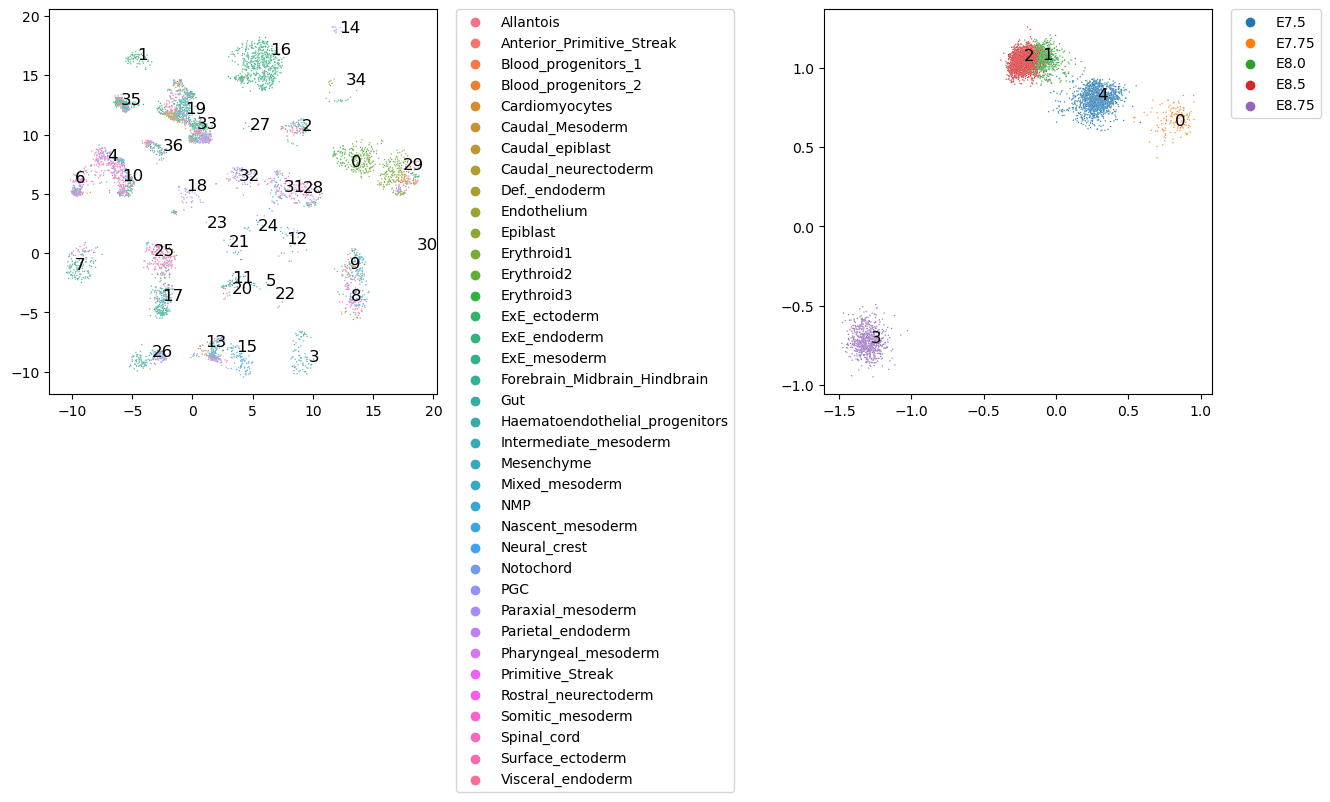

In [34]:
rep = reducer.transform(model.test_rep.z.detach().cpu().numpy())

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# adjust spacing
fig.subplots_adjust(wspace=1.)
sns.scatterplot(
    x=rep[:, 0],
    y=rep[:, 1],
    hue=testset.obs["celltype"].values,
    s=1,
    ax=ax[0]
)
# plot the gmm means as numbers on the plot
for i in range(gmm.shape[0]):
    ax[0].text(gmm[i, 0], gmm[i, 1], str(i), fontsize=12)
sns.scatterplot(
    x=model.correction_test_rep.z.detach().cpu().numpy()[:, 0],
    y=model.correction_test_rep.z.detach().cpu().numpy()[:, 1],
    hue=testset.obs["stage"].values,
    s=1,
    ax=ax[1]
)
for i in range(model.correction_gmm.n_mix_comp):
    ax[1].text(model.correction_gmm.mean.detach().cpu().numpy()[i, 0], model.correction_gmm.mean.detach().cpu().numpy()[i, 1], str(i), fontsize=12)
ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [39]:
model = None

In [36]:
i = 0
model_name = "mouse_gast_l20_h2-2_rs0_leftout_E7.5_test100e_covSupervised_beta5"

# load model
train_indices = [
    x
    for x in np.arange(len(trainset))
    if trainset.obs["stage"].values[x] != batches_left_out[i]
]
model = DGD.load(
    data=trainset[train_indices],
    save_dir=save_dir + data_name + "/",
    model_name=model_name,
)

CUDA Available: False
Number of GPUs: 0
using device:  cpu

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 4
        
printing all checkpoint keys containing 'correction'
correction_gmm.mean
correction_gmm.neglogvar
correction_gmm.weight
correction_rep.z
correction_val_rep.z
correction_test_rep.z
#######################
Training status
#######################
True


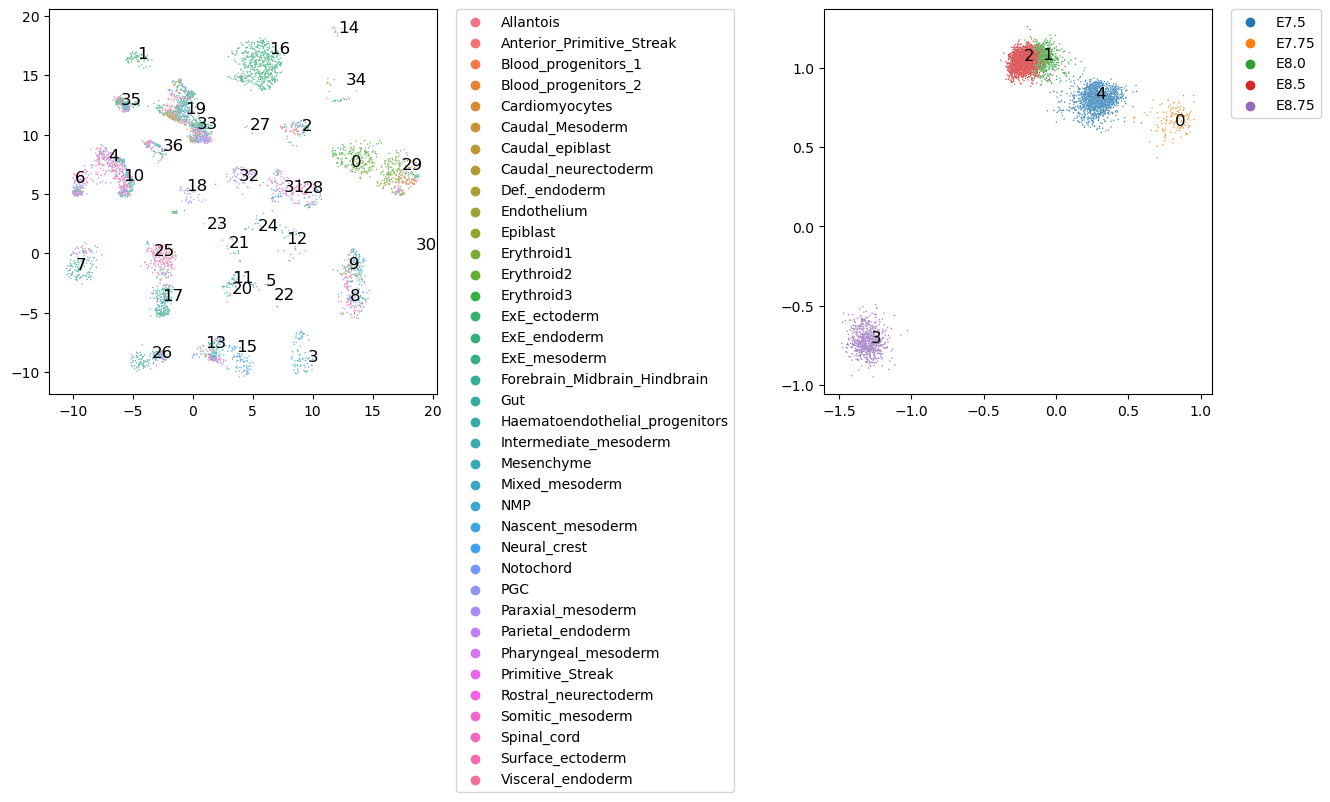

In [37]:
rep = reducer.transform(model.test_rep.z.detach().cpu().numpy())

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# adjust spacing
fig.subplots_adjust(wspace=1.)
sns.scatterplot(
    x=rep[:, 0],
    y=rep[:, 1],
    hue=testset.obs["celltype"].values,
    s=1,
    ax=ax[0]
)
# plot the gmm means as numbers on the plot
for i in range(gmm.shape[0]):
    ax[0].text(gmm[i, 0], gmm[i, 1], str(i), fontsize=12)
sns.scatterplot(
    x=model.correction_test_rep.z.detach().cpu().numpy()[:, 0],
    y=model.correction_test_rep.z.detach().cpu().numpy()[:, 1],
    hue=testset.obs["stage"].values,
    s=1,
    ax=ax[1]
)
for i in range(model.correction_gmm.n_mix_comp):
    ax[1].text(model.correction_gmm.mean.detach().cpu().numpy()[i, 0], model.correction_gmm.mean.detach().cpu().numpy()[i, 1], str(i), fontsize=12)
ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [40]:
i = 0
model_name = "mouse_gast_l20_h2-2_rs0_leftout_E7.5_test100e_covSupervised_beta5_finetuned"

# load model
train_indices = [
    x
    for x in np.arange(len(trainset))
    if trainset.obs["stage"].values[x] != batches_left_out[i]
]
model = DGD.load(
    data=trainset[train_indices],
    save_dir=save_dir + data_name + "/",
    model_name=model_name,
)

CUDA Available: False
Number of GPUs: 0
using device:  cpu

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 4
        
printing all checkpoint keys containing 'correction'
correction_gmm.mean
correction_gmm.neglogvar
correction_gmm.weight
correction_rep.z
correction_val_rep.z
correction_test_rep.z
#######################
Training status
#######################
True


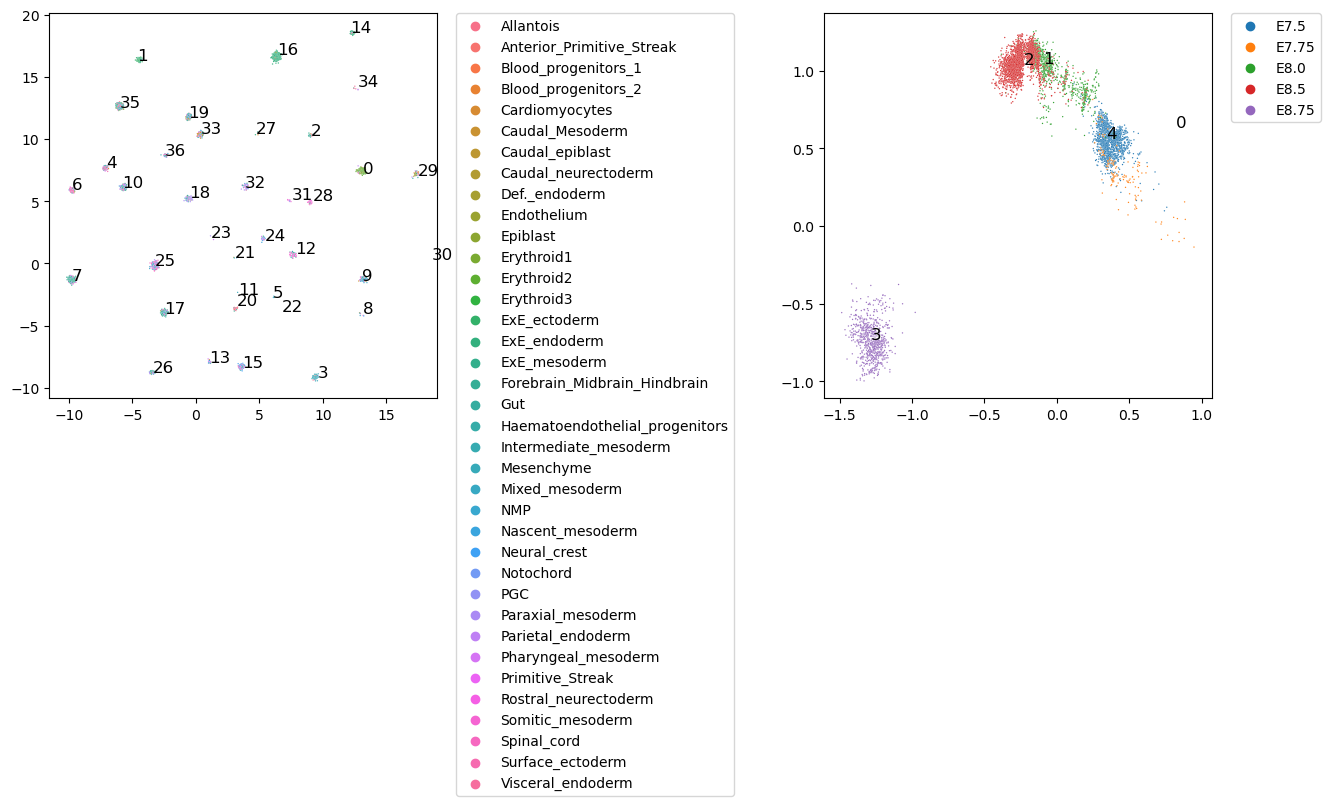

In [41]:
rep = reducer.transform(model.test_rep.z.detach().cpu().numpy())

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# adjust spacing
fig.subplots_adjust(wspace=1.)
sns.scatterplot(
    x=rep[:, 0],
    y=rep[:, 1],
    hue=testset.obs["celltype"].values,
    s=1,
    ax=ax[0]
)
# plot the gmm means as numbers on the plot
for i in range(gmm.shape[0]):
    ax[0].text(gmm[i, 0], gmm[i, 1], str(i), fontsize=12)
sns.scatterplot(
    x=model.correction_test_rep.z.detach().cpu().numpy()[:, 0],
    y=model.correction_test_rep.z.detach().cpu().numpy()[:, 1],
    hue=testset.obs["stage"].values,
    s=1,
    ax=ax[1]
)
for i in range(model.correction_gmm.n_mix_comp):
    ax[1].text(model.correction_gmm.mean.detach().cpu().numpy()[i, 0], model.correction_gmm.mean.detach().cpu().numpy()[i, 1], str(i), fontsize=12)
ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

/var/folders/tp/pr1hfl8527z35j1791t_j9bc0000gn/T/ipykernel_7324/2377522760.py:19: RuntimeWarning: invalid value encountered in scalar divide
  confusion_matrix[i, cluster] = np.sum(clusters == cluster) / len(site_indices)


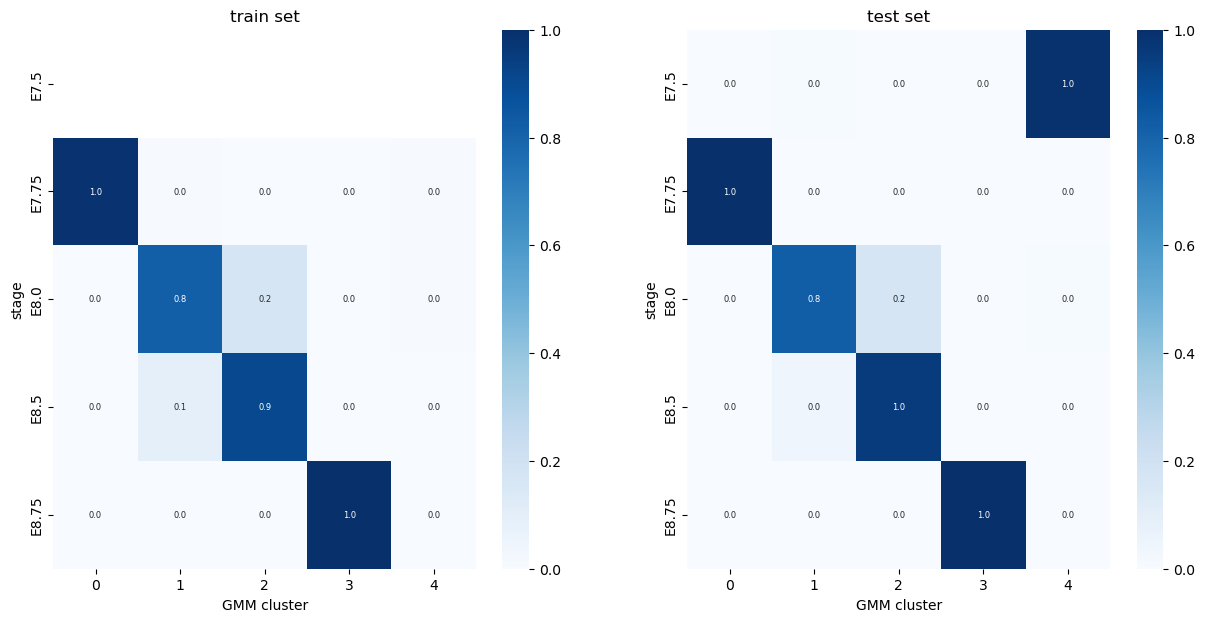

In [38]:
# get the components that the train samples are in (for basal and covariate)
train_basal_clusters = torch.argmax(model.gmm.sample_probs(model.representation.z),dim=-1).to(torch.int16)
train_covariate_clusters = torch.argmax(model.correction_gmm.sample_probs(model.correction_rep.z),dim=-1).to(torch.int16)
test_basal_clusters = torch.argmax(model.gmm.sample_probs(model.test_rep.z),dim=-1).to(torch.int16)
test_covariate_clusters = torch.argmax(model.correction_gmm.sample_probs(model.correction_test_rep.z),dim=-1).to(torch.int16)

sites = trainset.obs["stage"].unique()
confusion_matrix = np.zeros((len(sites), model.correction_gmm.n_mix_comp))
confusion_matrix_test = np.zeros((len(sites), model.correction_gmm.n_mix_comp))
for i, site in enumerate(sites):
    # get the indices of the trainset that are of this celltype
    site_indices = np.where(trainset[train_indices].obs["stage"].values == site)[0]
    site_indices_test = np.where(testset.obs["stage"].values == site)[0]
    # get the clusters that these indices are in
    clusters = train_covariate_clusters[site_indices].cpu().numpy()
    clusters_test = test_covariate_clusters[site_indices_test].cpu().numpy()
    # count the number of cells in each cluster
    for cluster in range(model.correction_gmm.n_mix_comp):
        confusion_matrix[i, cluster] = np.sum(clusters == cluster) / len(site_indices)
        confusion_matrix_test[i, cluster] = np.sum(clusters_test == cluster) / len(site_indices_test)

# plot the confusion matrix
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
sns.heatmap(confusion_matrix, cmap="Blues", annot=True, xticklabels=np.arange(model.correction_gmm.n_mix_comp), yticklabels=sites, fmt=".1f", ax=ax[0], annot_kws={"fontsize": 6})
ax[0].set_xlabel("GMM cluster")
ax[0].set_ylabel("stage")
ax[0].set_title("train set")
sns.heatmap(confusion_matrix_test, cmap="Blues", annot=True, xticklabels=np.arange(model.correction_gmm.n_mix_comp), yticklabels=sites, fmt=".1f", ax=ax[1], annot_kws={"fontsize": 6})
ax[1].set_xlabel("GMM cluster")
ax[1].set_ylabel("stage")
ax[1].set_title("test set")
plt.show()